In [1]:
#importing necessary libraries and the cleaned survey df
from cleaned_survey import df
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings('ignore')

In [2]:
#exploration of data
df.head()

,Timestamp,1. Have you ever been to Universal Studios?,2. How frequently do you visit a theme park?,3. What is your age?,4. What is your gender?,5. What is your monthly income?,"6. What is your nationality? If you select ""Other"", please specify.",7. Who do you usually go to theme parks with? (Select all that apply),8. What types of rides do you prefer?,9. What time of the day are you usually in the theme park? (Select all that apply),...,"28. What dissuades you from wanting to visit a theme park? If you select ""Other"", please specify",29. How do you typically decide which attractions to visit at a theme park?,"30. What do you spend the most money on in a theme park (excluding the admission ticket)? If you select ""Other"", please specify",31. (Optional - only if you have recently been to USS) Which areas did you visit and in what order? (Select only the areas which you have visited) [Hollywood],31. (Optional - only if you have recently been to USS) Which areas did you visit and in what order? (Select only the areas which you have visited) [Minion Land],31. (Optional - only if you have recently been to USS) Which areas did you visit and in what order? (Select only the areas which you have visited) [Far Far Away],31. (Optional - only if you have recently been to USS) Which areas did you visit and in what order? (Select only the areas which you have visited) [The Lost World],31. (Optional - only if you have recently been to USS) Which areas did you visit and in what order? (Select only the areas which you have visited) [Ancient Egypt],31. (Optional - only if you have recently been to USS) Which areas did you visit and in what order? (Select only the areas which you have visited) [Sci-fi City],31. (Optional - only if you have recently been to USS) Which areas did you visit and in what order? (Select only the areas which you have visited) [New York]
0,2025/02/15 7:01:29 PM GMT+8,Yes,Once every 2-3 years,19-25 years old,Female,No income,singaporean/pr,Friends;Family,High-intensity rides,Morning (10am-12pm);Afternoon (12pm-5pm);Eveni...,...,"Crowd;Costs (F&B, admission tickets, etc.);Lon...",A mix of both of the above —some planned rides...,F&B,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2025/02/16 10:44:01 AM GMT+8,Yes,Once every 2-3 years,19-25 years old,Female,No income,singaporean/pr,Friends;Family,High-intensity rides,Morning (10am-12pm);Afternoon (12pm-5pm);Eveni...,...,"Crowd;Costs (F&B, admission tickets, etc.);Lon...",I stick to the few rides/attractions that I en...,F&B,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2025/02/16 11:16:22 AM GMT+8,Yes,When on vacation,19-25 years old,Male,No income,singaporean/pr,Friends;Family,Medium-intensity rides,Morning (10am-12pm);Afternoon (12pm-5pm),...,"Crowd;Costs (F&B, admission tickets, etc.);Lon...",A mix of both of the above —some planned rides...,F&B,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2025/02/16 11:22:17 AM GMT+8,Yes,< Once every 3 years,46-54 years old,Female,"$6,000 - $9,999",singaporean/pr,Family,Low-intensity rides,Morning (10am-12pm),...,"Crowd;Costs (F&B, admission tickets, etc.);Lon...",A mix of both of the above —some planned rides...,"Transportation (e.g. Parking, taxi fares etc.)",NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2025/02/16 11:22:40 AM GMT+8,Yes,< Once every 3 years,55 and above,Female,No income,singaporean/pr,Family,I do not go on any rides,Morning (10am-12pm);Afternoon (12pm-5pm);Eveni...,...,"Costs (F&B, admission tickets, etc.);Unpredict...",A mix of both of the above —some planned rides...,F&B,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
#making new dataframe consisting of only variables of interest to guest segmentation
demographics = df.iloc[:,2:9]
spending_cat = df.iloc[:,37]

new_df = pd.concat([demographics,spending_cat], axis = 1)
new_df.head()

,2. How frequently do you visit a theme park?,3. What is your age?,4. What is your gender?,5. What is your monthly income?,"6. What is your nationality? If you select ""Other"", please specify.",7. Who do you usually go to theme parks with? (Select all that apply),8. What types of rides do you prefer?,"30. What do you spend the most money on in a theme park (excluding the admission ticket)? If you select ""Other"", please specify"
0,Once every 2-3 years,19-25 years old,Female,No income,singaporean/pr,Friends;Family,High-intensity rides,F&B
1,Once every 2-3 years,19-25 years old,Female,No income,singaporean/pr,Friends;Family,High-intensity rides,F&B
2,When on vacation,19-25 years old,Male,No income,singaporean/pr,Friends;Family,Medium-intensity rides,F&B
3,< Once every 3 years,46-54 years old,Female,"$6,000 - $9,999",singaporean/pr,Family,Low-intensity rides,"Transportation (e.g. Parking, taxi fares etc.)"
4,< Once every 3 years,55 and above,Female,No income,singaporean/pr,Family,I do not go on any rides,F&B


In [4]:
#renaming the columns for easy access
new_df.columns = ['frequency','age','gender','monthly_income','nationality','companion','ride_intensity','spending_cat']
new_df.head()

,frequency,age,gender,monthly_income,nationality,companion,ride_intensity,spending_cat
0,Once every 2-3 years,19-25 years old,Female,No income,singaporean/pr,Friends;Family,High-intensity rides,F&B
1,Once every 2-3 years,19-25 years old,Female,No income,singaporean/pr,Friends;Family,High-intensity rides,F&B
2,When on vacation,19-25 years old,Male,No income,singaporean/pr,Friends;Family,Medium-intensity rides,F&B
3,< Once every 3 years,46-54 years old,Female,"$6,000 - $9,999",singaporean/pr,Family,Low-intensity rides,"Transportation (e.g. Parking, taxi fares etc.)"
4,< Once every 3 years,55 and above,Female,No income,singaporean/pr,Family,I do not go on any rides,F&B


In [5]:
#data processing and feature engineering
#mapping frequencies to rare, moderate, frequent, traveller
freq_mapping = {
    '< Once every 3 years': 'rare',
    'Once every 2-3 years': 'rare',
    'Once every year': 'moderate',
    'A few times every year': 'frequent',
    'Once every month': 'frequent',
    '> Once every month': 'frequent',
    'When on vacation': 'traveller'
}
new_df['frequency'] = new_df['frequency'].replace(freq_mapping) 

#mapping age to young, adults, middle-aged, elderly
age_mapping = {
    '<15 years old': 'young',
    '15-18 years old': 'young',
    '19-25 years old': 'adult',
    '26-35 years old': 'adult',
    '36-45 years old': 'middle-aged',
    '46-54 years old': 'middle-aged',
    '55 and above': 'elderly'
}
new_df['age'] = new_df['age'].replace(age_mapping)

#mapping monthly income to low, middle and high
income_mapping = {
    'No income':'low',
    'Below $2000': 'low',
    '$2,000 - $5,999': 'middle',
    '$6,000 - $9,999': 'middle',
    '$10,000 - $19,999': 'high',
    '$20,000 and above': 'high'
}
new_df['monthly_income'] = new_df['monthly_income'].replace(income_mapping)

#mapping nationality to singaporean/pr and foreigners
new_df['nationality'] = new_df['nationality'].apply(lambda x: 'foreigners' if x != 'singaporean/pr' else x)

#pivoting the dataframe such that each companion option becomes a binary column

df_expanded = (new_df['companion'].str.get_dummies(sep=';'))
df_expanded.columns = ['couple','family','friends','single']
new_df = new_df.join(df_expanded)
new_df = new_df.drop('companion', axis = 1)

new_df

,frequency,age,gender,monthly_income,nationality,ride_intensity,spending_cat,couple,family,friends,single
0,rare,adult,Female,low,singaporean/pr,High-intensity rides,F&B,0,1,1,0
1,rare,adult,Female,low,singaporean/pr,High-intensity rides,F&B,0,1,1,0
2,traveller,adult,Male,low,singaporean/pr,Medium-intensity rides,F&B,0,1,1,0
3,rare,middle-aged,Female,middle,singaporean/pr,Low-intensity rides,"Transportation (e.g. Parking, taxi fares etc.)",0,1,0,0
4,rare,elderly,Female,low,singaporean/pr,I do not go on any rides,F&B,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
162,moderate,adult,Male,low,singaporean/pr,Medium-intensity rides,"Transportation (e.g. Parking, taxi fares etc.)",0,1,1,0
163,rare,adult,Female,low,singaporean/pr,High-intensity rides,F&B,0,1,1,0
164,rare,adult,Female,low,singaporean/pr,High-intensity rides,F&B,0,0,1,0
165,rare,adult,Female,middle,singaporean/pr,High-intensity rides,F&B,0,1,1,0


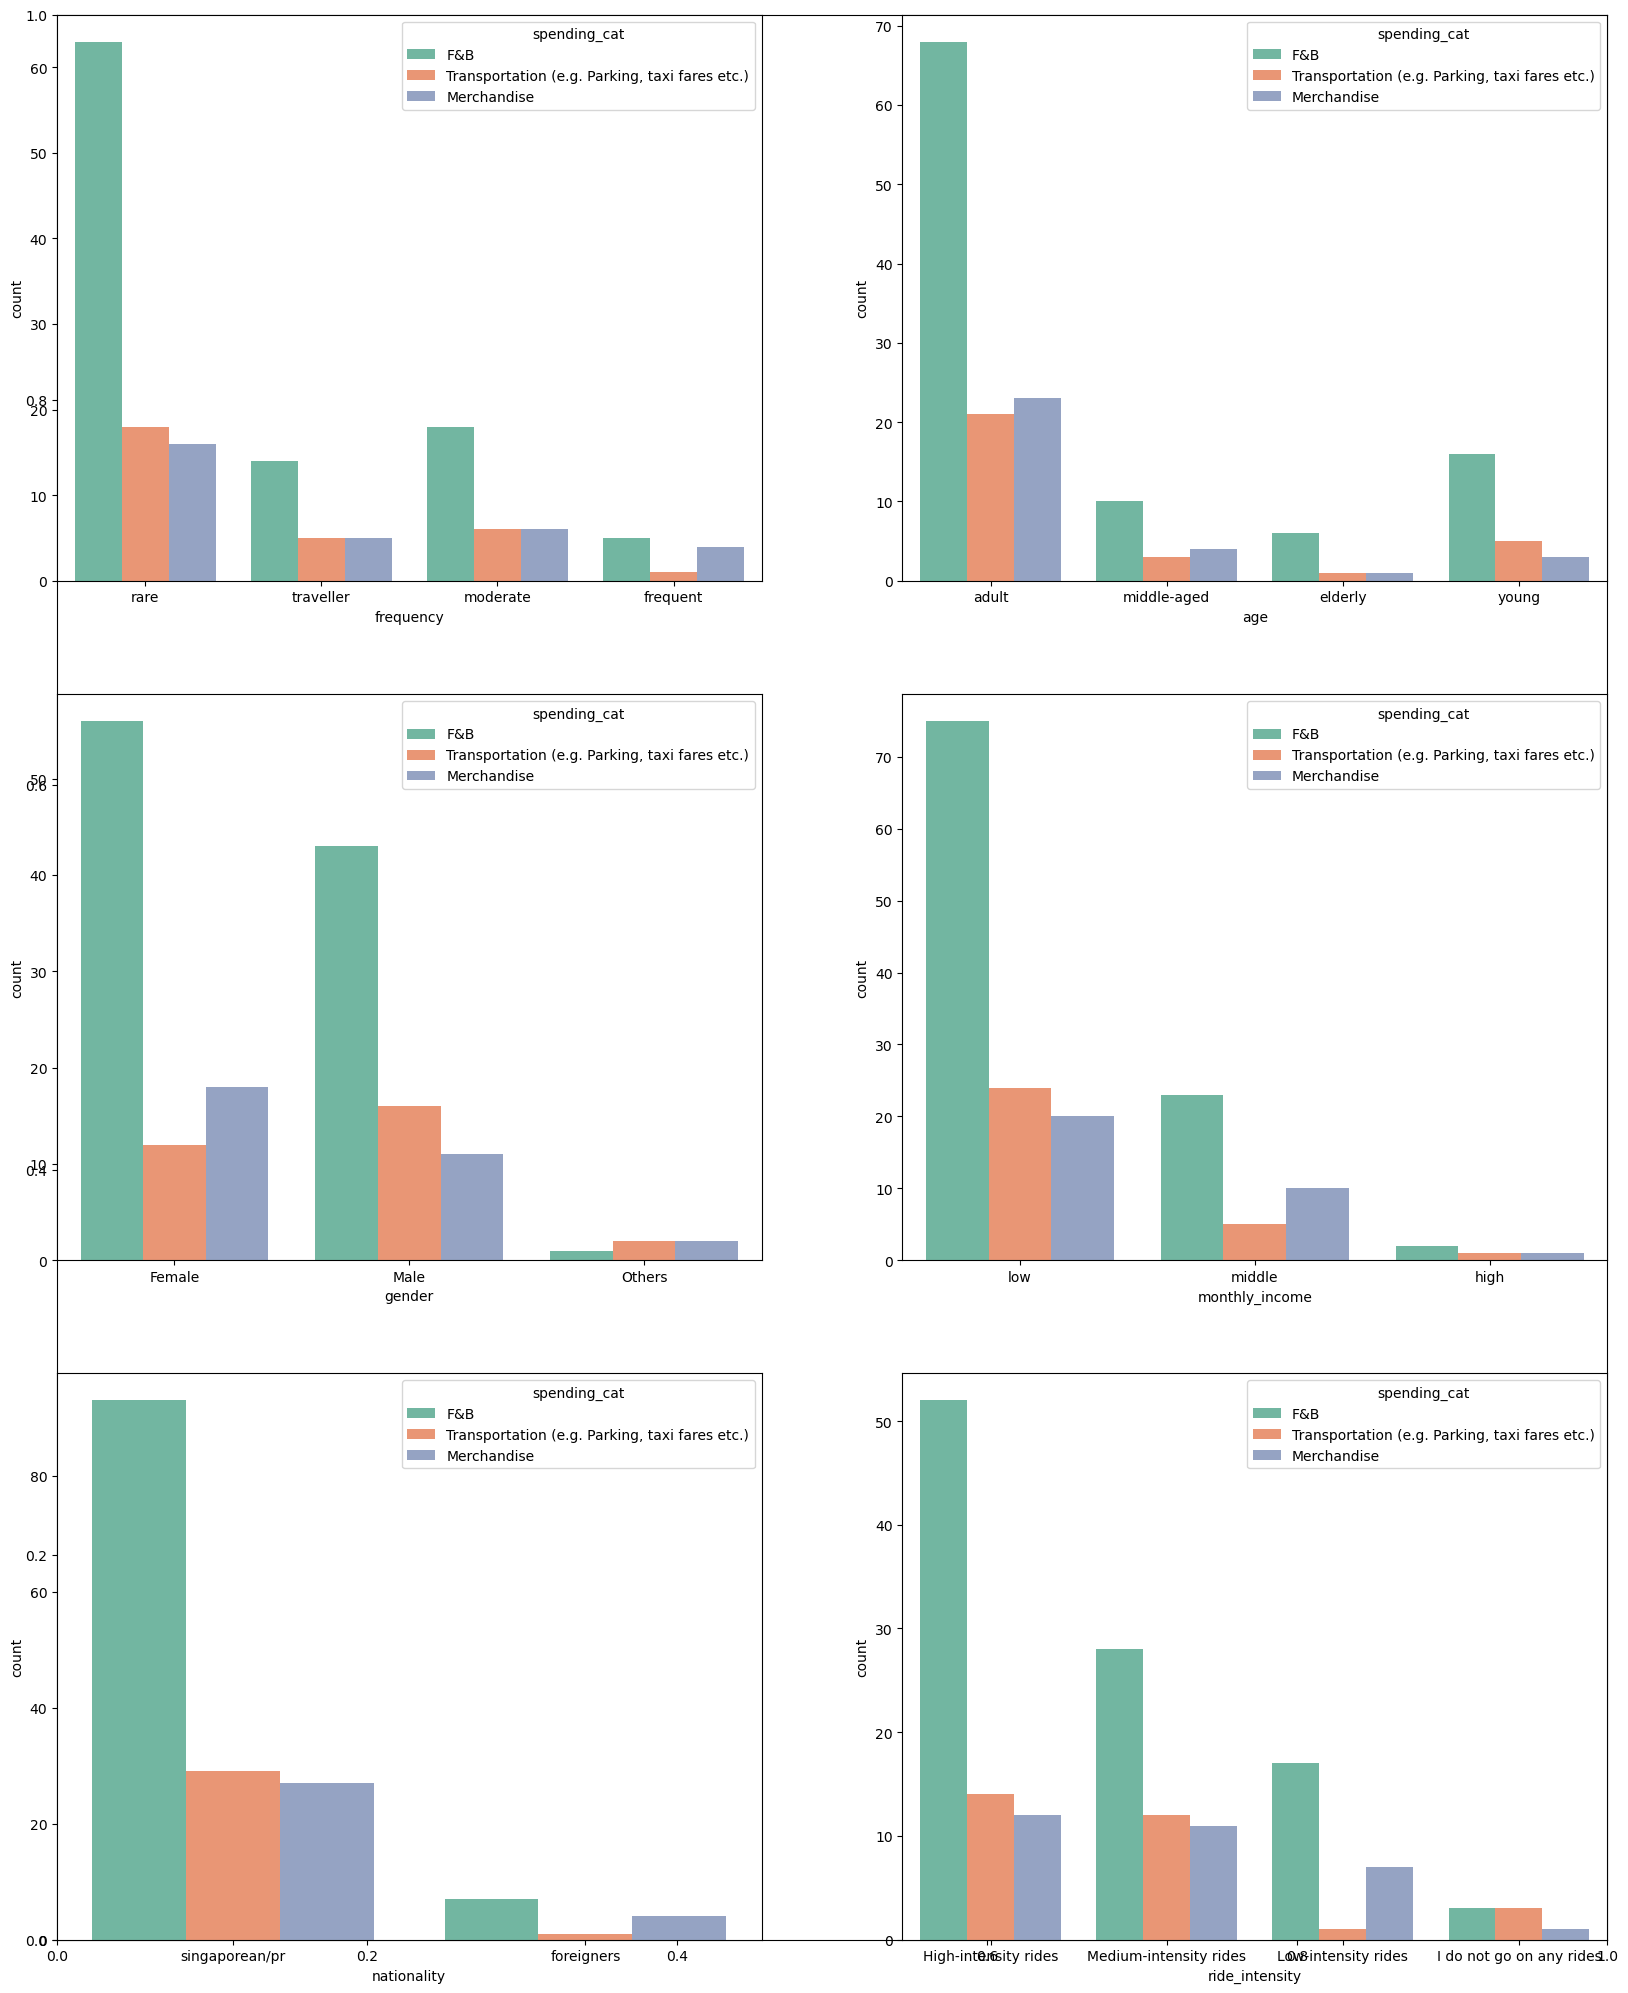

In [6]:
#exploratory data visualisations of each demographic and their highest spending category
objects = []
for col in new_df.columns:
    if new_df[col].dtype == object:
        objects.append(col)
objects.remove('spending_cat')

plt.subplots(figsize=(20, 25))
for i, col in enumerate(objects):
    plt.subplot(3, 2, i + 1)
    sb.countplot(x=col, hue='spending_cat', data=new_df, palette='Set2')
plt.show()

In [7]:
#convert all categorical values into numerical values
for col in new_df.columns:
    if new_df[col].dtype == object:
        le = LabelEncoder()
        new_df[col] = le.fit_transform(new_df[col])

new_df.head()

,frequency,age,gender,monthly_income,nationality,ride_intensity,spending_cat,couple,family,friends,single
0,2,0,0,1,1,0,0,0,1,1,0
1,2,0,0,1,1,0,0,0,1,1,0
2,3,0,1,1,1,3,0,0,1,1,0
3,2,2,0,2,1,2,2,0,1,0,0
4,2,1,0,1,1,1,0,0,1,0,0


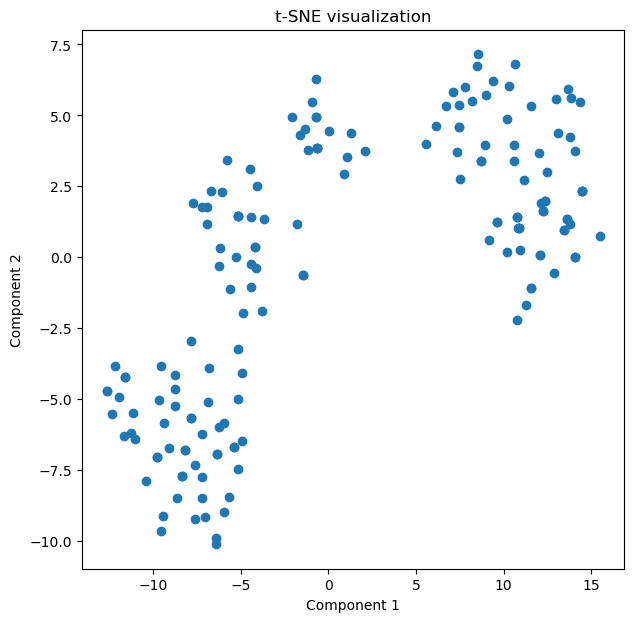

In [8]:
#t-SNE visualization of data
from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0) #create 2D representation of data
tsne_data = model.fit_transform(new_df)

#plotting t-SNE
plt.figure(figsize=(7, 7))
plt.scatter(tsne_data[:, 0], tsne_data[:, 1])
plt.title('t-SNE visualization')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.show()

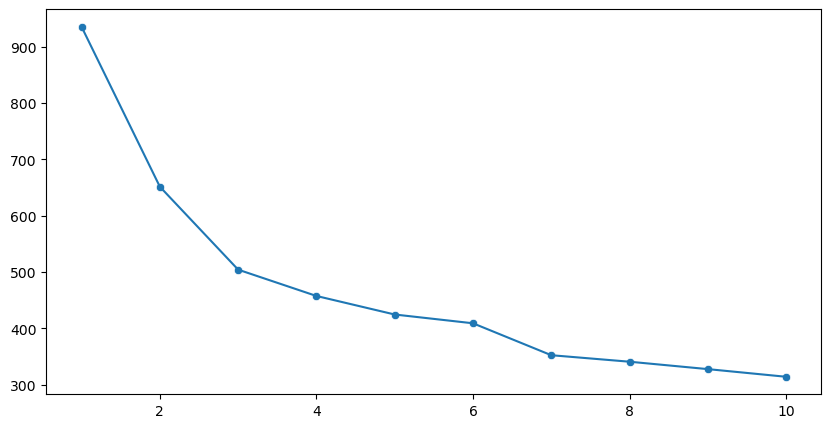

In [9]:
#apply k-means clustering to new_df
error = []
for i in range(1, 11):
    model = KMeans(init='k-means++',
                   n_clusters=i,
                   max_iter=500,
                   random_state=5)
    model.fit(new_df)
    error.append(model.inertia_)

#plot the error for each k
plt.figure(figsize=(10, 5))
sb.lineplot(x=range(1, 11), y=error)
sb.scatterplot(x=range(1, 11), y=error)
plt.show()

In [10]:
#fit kmeans with k = 3 using elbow method from the plot above
model = KMeans(init='k-means++',
                   n_clusters=3,
                   max_iter=500,
                   random_state=5)
clusters = model.fit_predict(new_df)

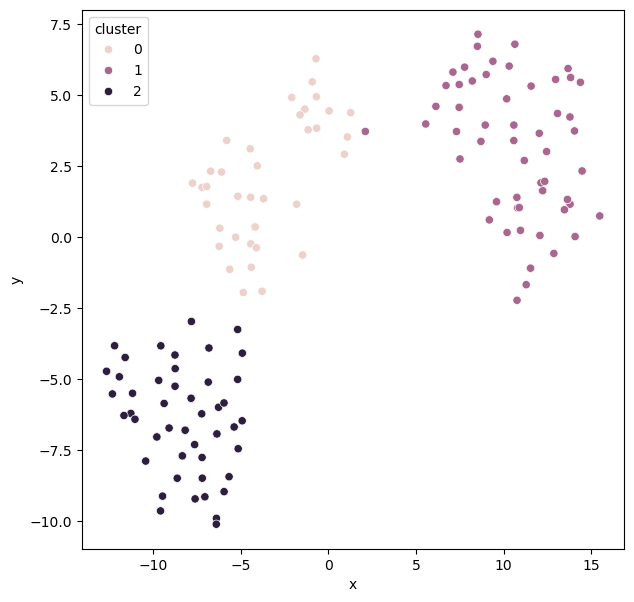

In [11]:
#plotting the 3 clusters formed by kmeans clustering
plt.figure(figsize=(7, 7))
df_tsne = pd.DataFrame({'x': tsne_data[:, 0], 'y': tsne_data[:, 1], 'cluster': clusters})
sb.scatterplot(x='x', y='y', hue='cluster', data=df_tsne)
plt.show()

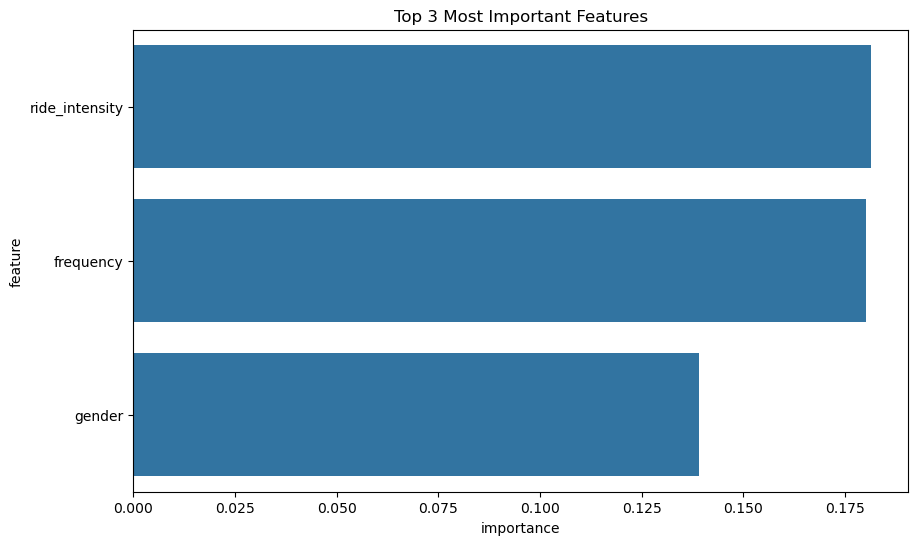

In [15]:
#feature importance using random forest
from sklearn.ensemble import RandomForestClassifier

X = new_df.drop('spending_cat', axis=1)
y = new_df['spending_cat']

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

feature_importance = pd.DataFrame({'feature': X.columns, 'importance': rf.feature_importances_})
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sb.barplot(x='importance', y='feature', data=feature_importance.head(3))
plt.title('Top 3 Most Important Features')
plt.show()

In [23]:
new_df[new_df['ride_intensity']==0]

,frequency,age,gender,monthly_income,nationality,ride_intensity,spending_cat,couple,family,friends,single
0,2,0,0,1,1,0,0,0,1,1,0
1,2,0,0,1,1,0,0,0,1,1,0
6,2,0,1,1,1,0,2,1,0,1,0
7,2,0,0,1,1,0,0,0,0,1,0
8,2,0,0,2,1,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...
161,2,0,1,1,1,0,0,0,0,1,0
163,2,0,0,1,1,0,0,0,1,1,0
164,2,0,0,1,1,0,0,0,0,1,0
165,2,0,0,2,1,0,0,0,1,1,0
